In [1]:
import pandas as pd
df = pd.read_csv(r'/content/NYC.csv')

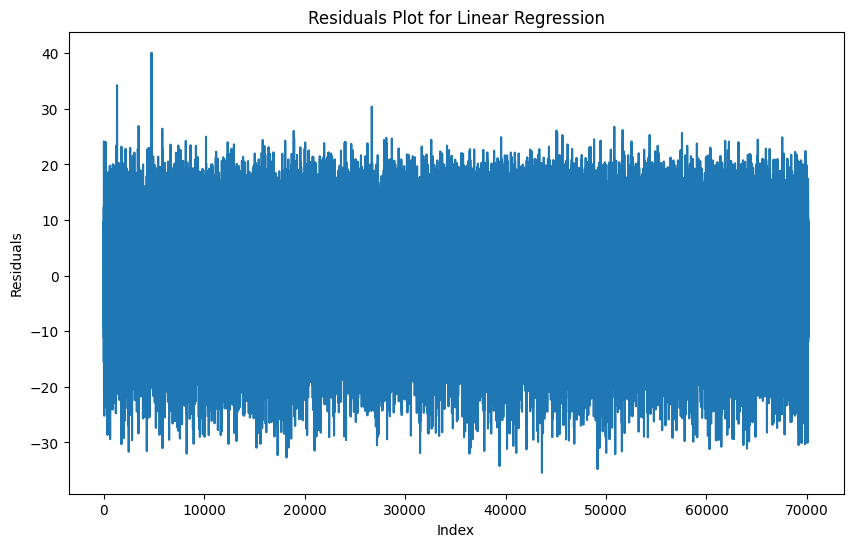

LinearRegression()


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = df[['relative_humidity_2m', 'precipitation', 'rain', 'snowfall', 'wind_speed_10m', 'wind_gusts_10m']]
y = df['temperature_2m']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()
linear_regr = LinearRegression()
linear_regr.fit(X_train_scaled, y_train_scaled)
y_pred_scaled_linear = linear_regr.predict(X_train_scaled)
y_pred_linear = scaler_y.inverse_transform(y_pred_scaled_linear.reshape(-1, 1)).ravel()
r2_linear = r2_score(y_train, y_pred_linear)
l = list(range(len(y_pred_scaled_linear)))
plt.figure(figsize=(10, 6))
plt.plot(l, y_train - y_pred_linear)
plt.title('Residuals Plot for Linear Regression')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.show()

print(linear_regr)


In [4]:
import pandas as pd
data = {'max_temp': []}
output = pd.DataFrame(data)

In [7]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
import requests_cache
import pandas as pd
from retry_requests import retry
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "rain", "snowfall", "wind_speed_10m", "wind_gusts_10m"],
	"daily": "temperature_2m_max",
	"start_date": "2024-04-04",
	"end_date": "2024-04-04"
}
responses = openmeteo.weather_api(url, params=params)

response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(6).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

Coordinates 52.52000045776367°N 13.419998168945312°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                        date  temperature_2m  relative_humidity_2m  \
0  2024-04-04 00:00:00+00:00       10.045500                  89.0   
1  2024-04-04 01:00:00+00:00        9.945499                  88.0   
2  2024-04-04 02:00:00+00:00        9.695499                  90.0   
3  2024-04-04 03:00:00+00:00        9.745500                  93.0   
4  2024-04-04 04:00:00+00:00        9.295500                  94.0   
5  2024-04-04 05:00:00+00:00        9.045500                  91.0   
6  2024-04-04 06:00:00+00:00        9.395500                  90.0   
7  2024-04-04 07:00:00+00:00       10.745500                  83.0   
8  2024-04-04 08:00:00+00:00       12.145500                  73.0   
9  2024-04-04 09:00:00+00:00       13.695499                  63.0   
10 2024-04-04 10:00:00+00:00       13.445499                  67.0   
11 2024-04-04 11:00:00+00:00      

In [8]:
hourly_dataframe.drop(columns=['date'],inplace=True)

In [10]:
import numpy as np
for index, row in hourly_dataframe.iterrows():
    input_data = np.array([[row['relative_humidity_2m'],
                            row['precipitation'],
                            row['rain'],
                            row['snowfall'],
                            row['wind_speed_10m'],
                            row['wind_gusts_10m']]])
    predicted_output = linear_regr.predict(input_data)
    output.at[index, 'max_temp'] = predicted_output[0]


In [12]:
temp_max=output['max_temp'].max()

In [14]:
daily_dataframe

,date,temperature_2m_max
0,2024-04-04 00:00:00+00:00,14.445499


In [15]:
print(temp_max)

107.54994549352783


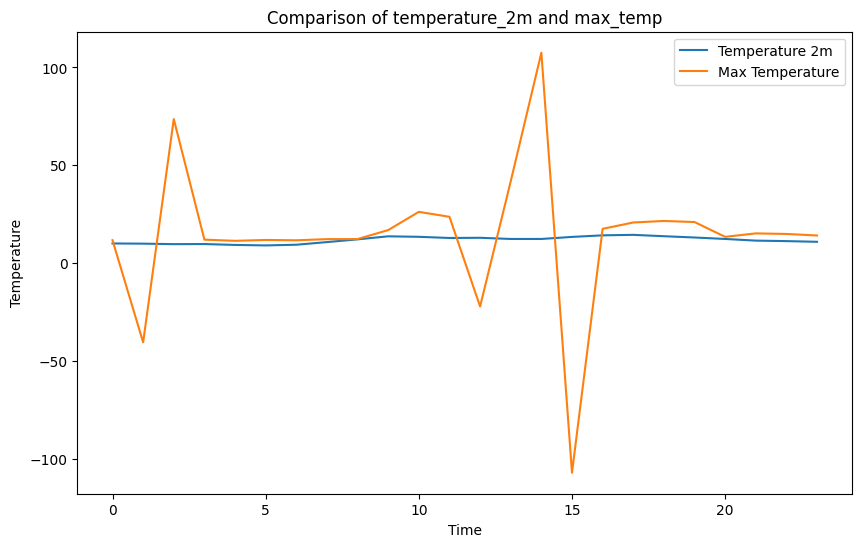

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hourly_dataframe.index, hourly_dataframe['temperature_2m'], label='Temperature 2m')
plt.plot(output.index, output['max_temp'], label='Max Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Comparison of temperature_2m and max_temp')
plt.legend()

plt.show()


As You can see Linear Regression is a real bad choice for this type of ML problem and the output data vs the actual temperature change has extreme variance

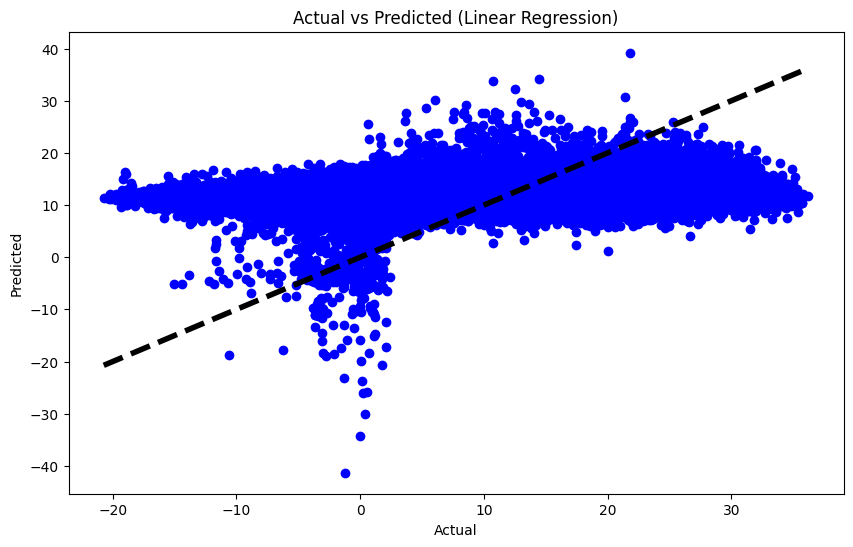

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_linear, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Linear Regression)')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


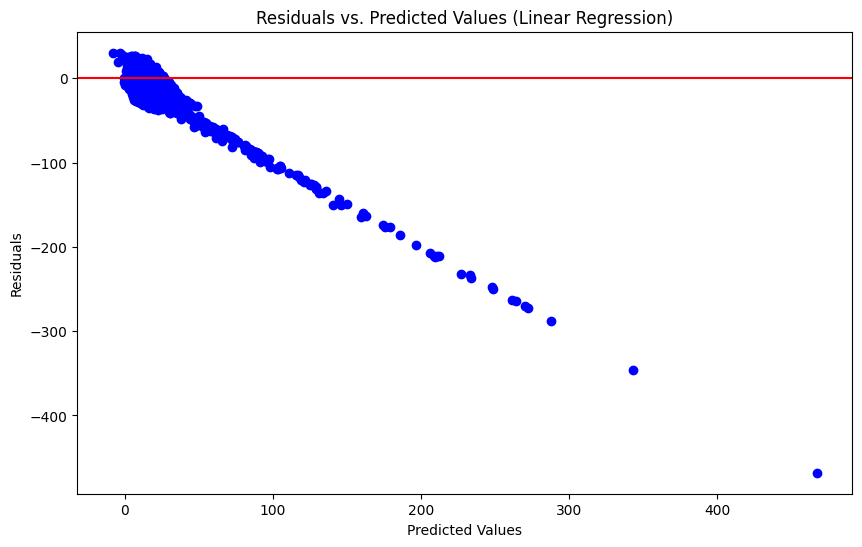

In [19]:
y_pred_linear_test = linear_regr.predict(X_test)
residuals_linear_test = y_test - y_pred_linear_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_linear_test, residuals_linear_test, color='blue')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values (Linear Regression)')
plt.show()


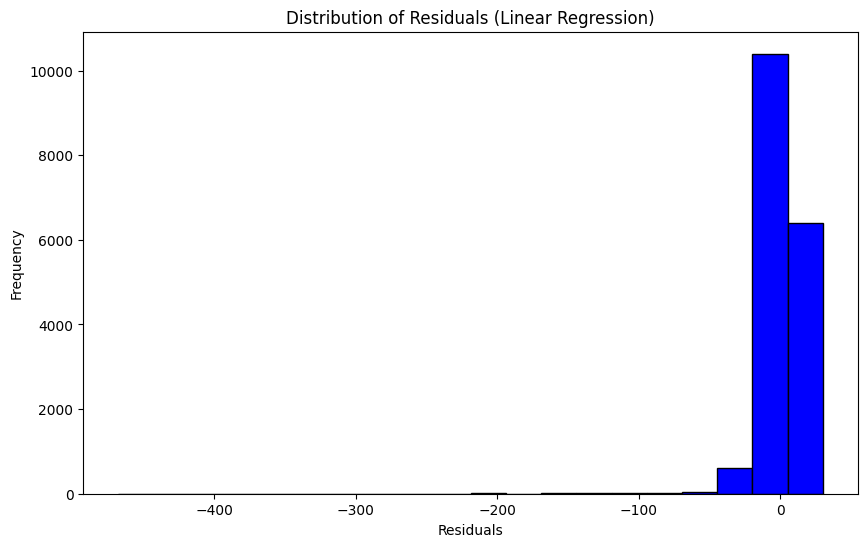

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(residuals_linear_test, bins=20, color='blue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Linear Regression)')
plt.show()


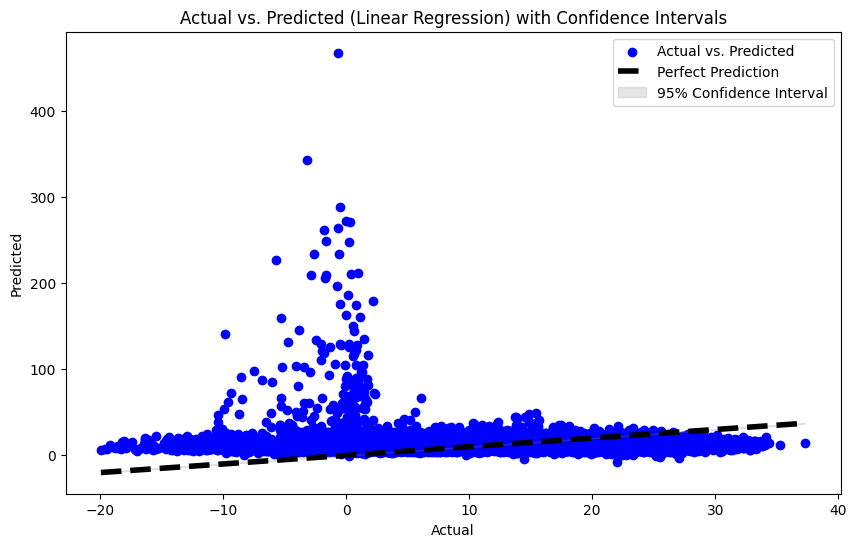

In [21]:
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error
confidence = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence) / 2)
mse_linear = mean_squared_error(y_test, y_pred_linear_test)
n_linear = len(y_test)
std_error_linear = np.sqrt(mse_linear / n_linear)
margin_of_error_linear = z_score * std_error_linear
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear_test, color='blue', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, label='Perfect Prediction')
plt.fill_between([y_test.min(), y_test.max()], [y_test.min() - margin_of_error_linear, y_test.max() - margin_of_error_linear],
                 [y_test.min() + margin_of_error_linear, y_test.max() + margin_of_error_linear], color='gray', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (Linear Regression) with Confidence Intervals')
plt.legend()
plt.show()


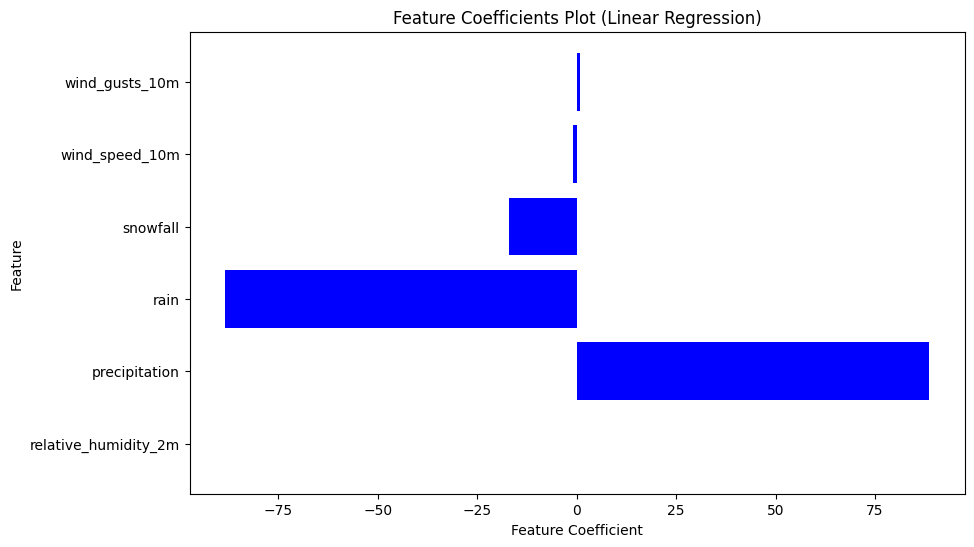

In [22]:
feature_coefficients = linear_regr.coef_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_coefficients, color='blue')
plt.xlabel('Feature Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients Plot (Linear Regression)')
plt.show()
